In [159]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [160]:
df = pd.read_csv(
    './datasets/complaint_census_join.csv',  
    names=[
        'zcta', 'complaint datetime', 'complaint type', 
        'complaint descriptor', 'hour', 'weekday', 'year', 'geoID', 'median earning', 
        'full time median earning', 'full time mean'])

## adding a helper counter
df['counter'] = 1

## cleaning
df = df[df['median earning'] != '-']

## casting meadian earning columns
df = df.astype({'median earning': 'int'}, errors='ignore')

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Year:  2019
Wealthiest...


/Users/jlrulff/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Poorest...


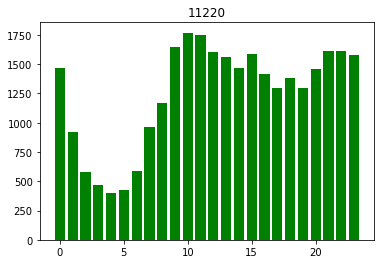

In [166]:
# years = [2020, 2019, 2018, 2017]
years = [2019]

for year in years:
    
    print('Year: ', year)
    
    ## filtering DF
    current_df = df[df['year'] == year]
    
    ## grouping DF by ZCTA and hour
    groupby = current_df[['zcta', 'hour', 'counter', 'median earning']].groupby(by=['zcta', 'hour']).agg({'counter': 'sum', 'median earning': 'first'})
    
    
#     ## clearning embeddings and earnings
#     embeddings, earnings = get_embeddings_and_earnings(groupby)
#     embeddings, earnings = filter_embeddings(embeddings, earnings)
    
#     ## plots
#     plot_PCA(embeddings, earnings, year)
#     plot_TSNE(embeddings, earnings, year)
    
    
    ## bar plots
    print('Wealthiest...')
    top_k = get_top_k(current_df, False, 8)
    xs,ys  = bar_plot(current_df, top_k)
    plot_bar_plot(xs, ys, top_k, year, 'wealthiest')
    
    print('Poorest...')
    last_k = get_top_k(current_df, True, 8)
    xs,ys  = bar_plot(current_df, last_k)
    plot_bar_plot(xs, ys, last_k, year, 'poorest')    
    

## Helper functions

In [164]:
def filter_embeddings(embeddings, earnings):
    
    final_embeddings = []
    final_earnings = []
    
    for i in range(embeddings.shape[0]):
        if(len(embeddings[i]) == 24):
            final_embeddings.append(embeddings[i])
            final_earnings.append( earnings[i] )
            
    return np.array(final_embeddings), np.array(final_earnings)
              
def get_mode_earnings(earnings):
    counts = np.bincount(earnings)
    return np.argmax(counts)


def get_embeddings_and_earnings(groupby):
    
    ## all different ZCTAs
    zctas = list(groupby.index.get_level_values(0).unique())

    embeddings = []
    earnings = []

    for zcta in zctas:

        current_embedding = []
        current_earnings = []

        for i in range(24):

            try:
                current_earnings.append(int(groupby.loc[zcta].loc[i]['median earning']))
                current_embedding.append(groupby.loc[zcta].loc[i]['counter'])
            except:
                current_earnings.append(0)

        earnings.append( get_mode_earnings(current_earnings) )
        embeddings.append(current_embedding)


    embeddings = np.array(embeddings)
    earnings = np.array(earnings)
    
    return embeddings, earnings



def plot_PCA(embeddings, earnings, year):
    
    ## PCA Projection
    pca = PCA(n_components=2)
    reduced_dim_data = pca.fit_transform(embeddings)

    x = reduced_dim_data[:,0]
    y = reduced_dim_data[:,1]
    plt.figure(figsize=(20, 10))
    plt.scatter(x, y, c=earnings, cmap='viridis')
    plt.colorbar()
    plt.title('PCA: ' + str(year))
    
    plt.savefig('./plots/' + 'PCA_' + str(year), bbox_inches='tight', pad_inches=0)


def plot_TSNE(embeddings, earnings, year):
    
    reduced_dim_data = TSNE(n_components=2).fit_transform(embeddings)
    x = reduced_dim_data[:,0]
    y = reduced_dim_data[:,1]
    plt.figure(figsize=(20, 10))
    plt.scatter(x, y, c=earnings, cmap='viridis')
    plt.colorbar()
    plt.title('TSNE: ' +  str(year))
    
    plt.savefig('./plots/' + 'TSNE_' + str(year), bbox_inches='tight', pad_inches=0)
    


def bar_plot(dataframe, zctas):
    
    hours = []
    timeseries = []
    
    for zcta in zctas:
        
        filtered_df = dataframe[ dataframe['zcta'] == zcta ]
        current_groupby = filtered_df[['zcta', 'hour', 'counter']].groupby(by=['zcta', 'hour']).sum()
        current_groupby.sort_index(ascending=True, inplace=True)
        
        current_timeseries = list(current_groupby['counter'].values)
        current_hours = [i for i in range(24)]
        
        hours.append(current_hours)
        timeseries.append(current_timeseries)
    
    
    return timeseries, hours

        
def plot_bar_plot(xs, ys, zcta, year, modifier):
    
    for index, x in enumerate(xs):
        
        if(len(x) == 24):
            
            plt.bar(ys[index], x, color='green')
            plt.title(zcta[index])
            
            plt.savefig( './plots/bar_plots_new/' + str(year) + '_' + str(zcta[index]) + '_' + modifier, bbox_inches='tight', pad_inches=0)
#             plt.show() 

        
    
def get_top_k(dataframe, ascending, k):
    
    topk = dataframe[['zcta','median earning']].groupby(by=['zcta', 'median earning']).first()
    topk.reset_index(inplace=True)
    topk = topk[topk['median earning'] != '-']
    topk.sort_values(by='median earning', ascending=ascending, inplace=True)
    topk = list(topk.iloc[0:k]['zcta'].values)
    
    
    return topk